In [1]:
# Importar bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib
import json

In [2]:
# Carregar o MirroredHealth
MirroredHealth = pd.read_csv('Impact_of_Mobile_Phone_on_Students_Health.csv')
MirroredHealth.columns = MirroredHealth.columns.str.strip()  # Limpar espaços nos nomes das colunas

In [3]:
# Remover colunas específicas - Colunas desnecessárias para nosso modelo de IA pois são identificadores de pessoas, não sendo gerais...
colunas_para_remover = ['Names', 'Mobile Phone']
MirroredHealth = MirroredHealth.drop(columns=[col for col in colunas_para_remover if col in MirroredHealth.columns])

In [4]:
# Definir uma largura máxima para as colunas (evita que fiquem cortadas)
pd.set_option('display.max_columns', None)  # Exibe todas as colunas
pd.set_option('display.width', 1000)  # Aumenta o tamanho da largura
pd.set_option('display.max_colwidth', None)  # Para exibir o conteúdo completo das células

# Exibir as primeiras 5 linhas
print(MirroredHealth.head())

     Age Gender Mobile Operating System Mobile phone use for education Mobile phone activities Helpful for studying    Educational Apps Daily usages Performance impact      Usage distraction Attention span   Useful features    Health Risks Beneficial subject     Usage symptoms Symptom frequency                 Health precautions Health rating
0  21-25   Male                 Android                      Sometimes            Social Media                  Yes  Educational Videos    4-6 hours              Agree           During Exams            Yes            Camera             Yes         Accounting           Headache             Never            Using Blue light filter     Excellent
1  21-25   Male                 Android                      Sometimes            Social Media                  Yes  Educational Videos    4-6 hours            Neutral           During Exams            Yes  Notes Taking App             Yes  Browsing Material       All of these         Sometimes  Taking Break 

In [5]:
# Codificação da variável 'Gender' para valores numéricos (Male = 1, Female = 0)
MirroredHealth['Gender'] = MirroredHealth['Gender'].map({'Male': 1, 'Female': 0})

In [6]:
# Listando todas as colunas do MirroredHealth
print(MirroredHealth.columns.tolist())

['Age', 'Gender', 'Mobile Operating System', 'Mobile phone use for education', 'Mobile phone activities', 'Helpful for studying', 'Educational Apps', 'Daily usages', 'Performance impact', 'Usage distraction', 'Attention span', 'Useful features', 'Health Risks', 'Beneficial subject', 'Usage symptoms', 'Symptom frequency', 'Health precautions', 'Health rating']


In [7]:
# Verificar os valores únicos de cada coluna, Age, Gender, etc...
print(MirroredHealth['Age'].unique())

['21-25' '16-20' '26-30' '31-35']


In [8]:
print(MirroredHealth[['Age', 'Mobile phone use for education']].isna().sum())

Age                               0
Mobile phone use for education    2
dtype: int64


In [9]:
# Preencher os valores ausentes com o valor mais frequente
MirroredHealth['Mobile phone use for education'].fillna(MirroredHealth['Mobile phone use for education'].mode()[0], inplace=True)

C:\Users\Aquiles\AppData\Local\Temp\ipykernel_21512\1602187904.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  MirroredHealth['Mobile phone use for education'].fillna(MirroredHealth['Mobile phone use for education'].mode()[0], inplace=True)


In [10]:
# Mapeamento de faixas etárias para valores numéricos
age_mapping = {
    '21-25': 23,
    '26-30': 28,
    '31-35': 33,
    '36-40': 38,
    '41-45': 43,
    '46-50': 48,
    '> 50': 55
}
MirroredHealth['Age'] = MirroredHealth['Age'].map(age_mapping)

# Mapeamento das variáveis ordinais
use_mapping = {
    'Never': 0,
    'Sometimes': 1,
    'Frequently': 2
}
MirroredHealth['Mobile phone use for education'] = MirroredHealth['Mobile phone use for education'].map(use_mapping)

health_mapping = {
    'Excellent': 3,
    'Good': 2,
    'Fair': 1,
    'Poor': 0
}
MirroredHealth['Health rating'] = MirroredHealth['Health rating'].map(health_mapping)

# Codificar colunas com valores como 'Yes', 'No', 'Agree', 'Strongly agree', etc.
label_encoder = LabelEncoder()

# Lista das colunas a serem codificadas
categorical_columns = [
    'Helpful for studying', 'Daily usages', 'Performance impact', 'Usage distraction',
    'Attention span', 'Useful features', 'Beneficial subject', 'Usage symptoms',
    'Symptom frequency', 'Health precautions'
]

# Aplicando o LabelEncoder
for col in categorical_columns:
    MirroredHealth[col] = label_encoder.fit_transform(MirroredHealth[col])

# Codificação One-Hot para as colunas que já foram identificadas como categóricas
MirroredHealth = pd.get_dummies(MirroredHealth, drop_first=True)

# Verificar as primeiras linhas após as transformações
print(MirroredHealth.head())

    Age  Gender  Mobile phone use for education  Helpful for studying  Daily usages  Performance impact  Usage distraction  Attention span  Useful features  Beneficial subject  Usage symptoms  Symptom frequency  Health precautions  Health rating  Mobile Operating System_IOS  Mobile phone activities_Messaging  Mobile phone activities_Social Media  Mobile phone activities_Social Media;All of these  Mobile phone activities_Social Media;Messaging  Mobile phone activities_Social Media;Web-browsing;Messaging;All of these  Mobile phone activities_Web-browsing  Educational Apps_Language  Educational Apps_Productivity Tools  Educational Apps_Study Planner  Health Risks_Only Partially  Health Risks_Yes
0  23.0       1                             1.0                     1             1                   0                  1               1                1                   0               2                  1                   3            3.0                        False                        

In [11]:
# Definir X (variáveis independentes) e y (variável alvo)
X = MirroredHealth.drop(['Health Risks_Only Partially', 'Health Risks_Yes'], axis=1)  # Remover as novas colunas de risco de saúde
y = MirroredHealth['Health Risks_Yes']  # Definindo 'Health Risks_Yes' como a variável alvo

# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados (escala dos valores das variáveis)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [12]:
X_train.shape

(80, 24)

In [13]:
# Criar e treinar o modelo Random Forest
model = RandomForestClassifier(n_estimators=300)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [14]:
# Fazer previsões com o conjunto de teste
y_pred = model.predict(X_test)

In [15]:
y_test

83     True
53    False
70     True
45    False
44    False
39     True
22     True
80     True
10     True
0      True
18     True
30     True
73     True
33    False
90     True
4     False
76    False
77     True
12     True
31    False
Name: Health Risks_Yes, dtype: bool

In [16]:
y_pred

array([ True, False,  True, False,  True,  True, False,  True, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False,  True])

In [17]:
# Avaliar o modelo com as métricas de desempenho
print('Acurácia é', accuracy_score(y_test, y_pred))
print('F1-score é', f1_score(y_test, y_pred, average='weighted'))
print('Sensibilidade é', recall_score(y_test, y_pred, average='weighted'))
print('Precisão é', precision_score(y_test, y_pred, average='weighted'))
print('\n\n\n', confusion_matrix(y_test, y_pred))

Acurácia é 0.6
F1-score é 0.6
Sensibilidade é 0.6
Precisão é 0.6



 [[3 4]
 [4 9]]


In [18]:
try:
    # Tenta salvar o modelo
    joblib.dump(model, 'modelo_treinado.pkl')
    print("Modelo salvo com sucesso!")
except Exception as e:
    # Se der erro, mostra a mensagem
    print("Erro ao salvar o modelo:", e)


Modelo salvo com sucesso!


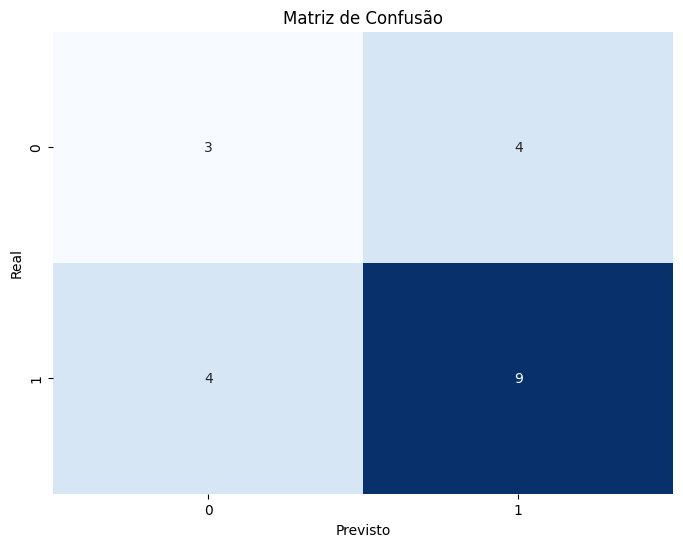

In [19]:
# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Cria o gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
# Matriz de confusão
plt.savefig("matriz_confusao.png")
plt.show()
plt.close()

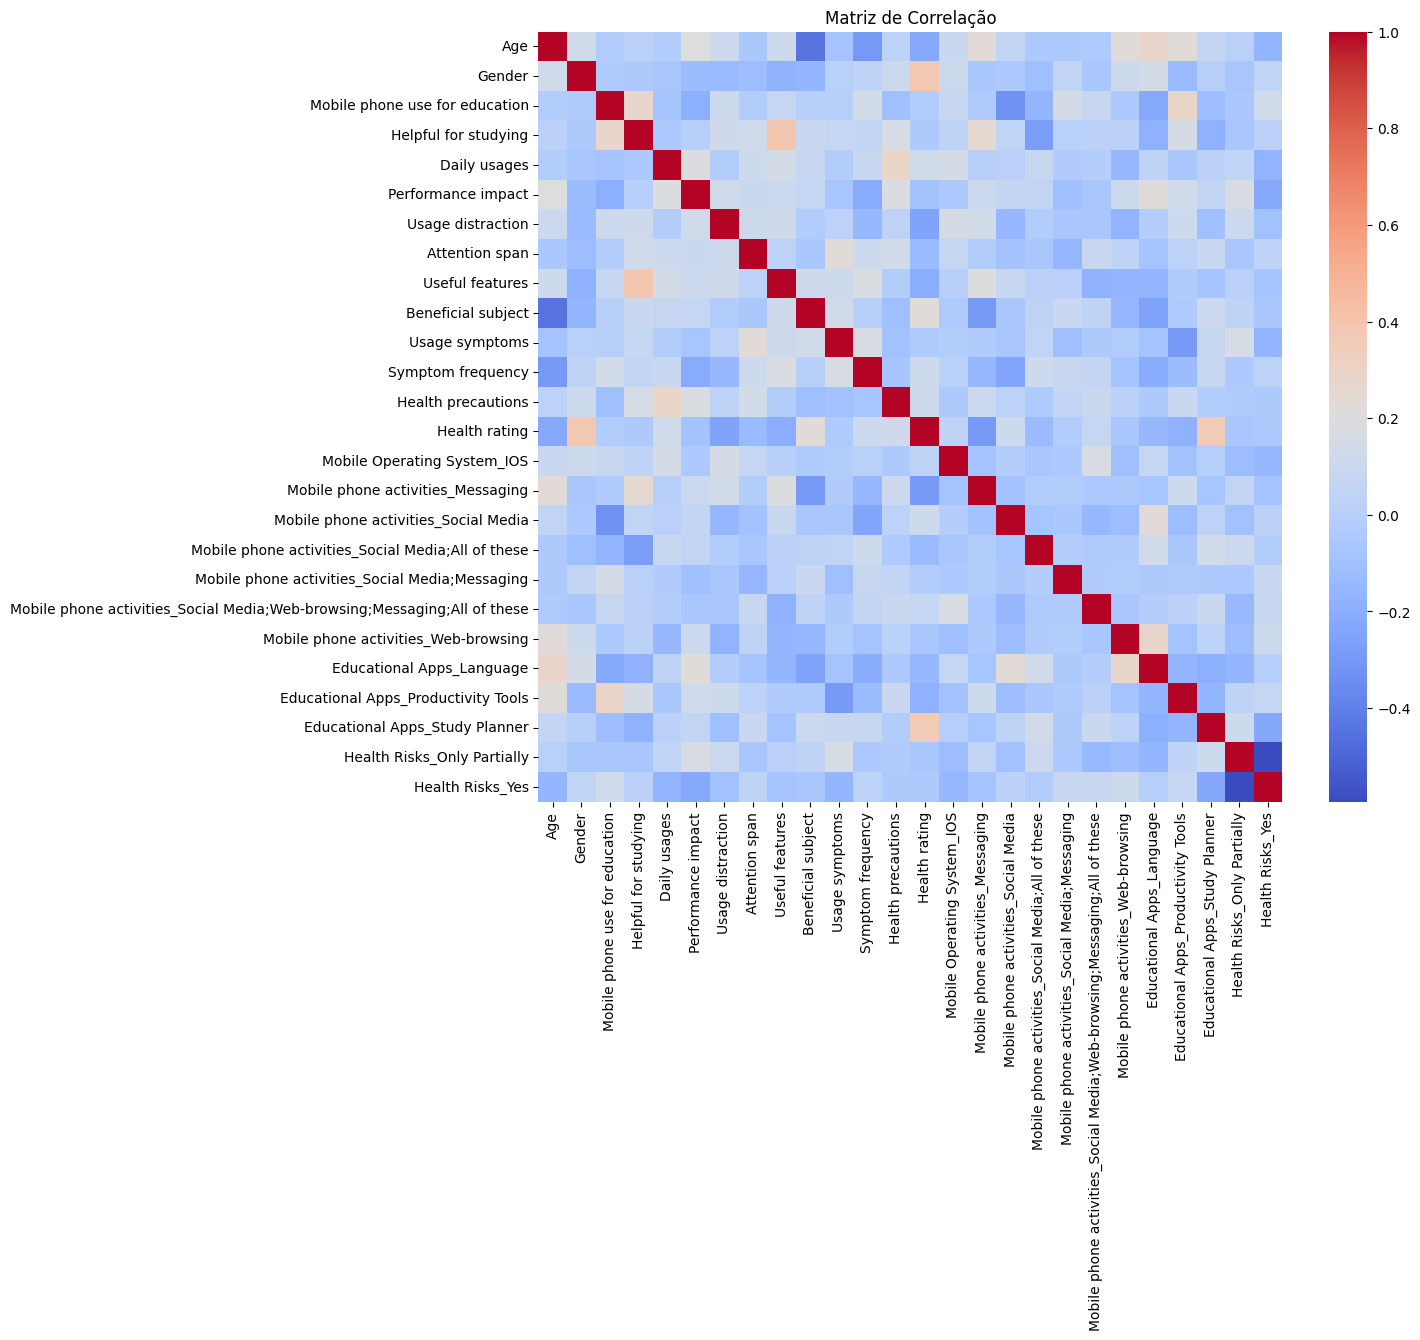

In [20]:
# Ver correlação entre variáveis
plt.figure(figsize=(12, 10))
sns.heatmap(MirroredHealth.corr(), cmap='coolwarm', annot=False)
plt.title('Matriz de Correlação')
# Matriz de correlação
plt.savefig("matriz_correlacao.png")
plt.show()
plt.close()


In [21]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1_weighted')
grid.fit(X_train, y_train)
print(grid.best_params_)


{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


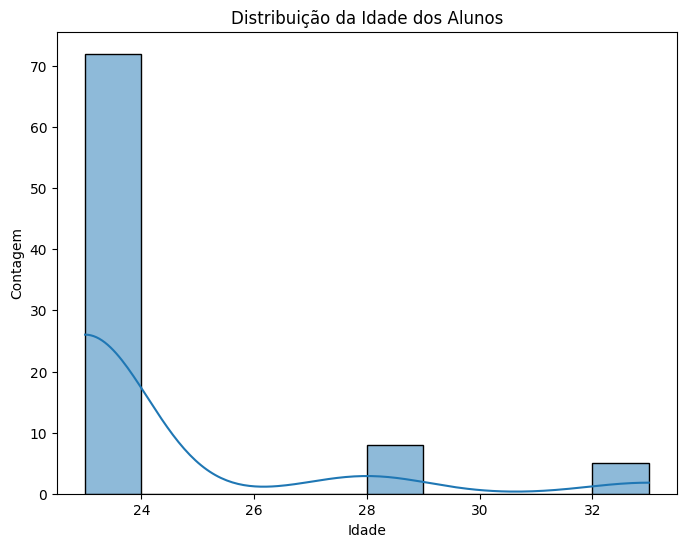

In [22]:
# Histograma da coluna 'Age'
plt.figure(figsize=(8, 6))
sns.histplot(data=MirroredHealth, x='Age', bins=10, kde=True)
plt.title('Distribuição da Idade dos Alunos')
plt.xlabel('Idade')
plt.ylabel('Contagem')
# Histograma da idade
plt.savefig("histograma_idade.png")
plt.show()
plt.close()


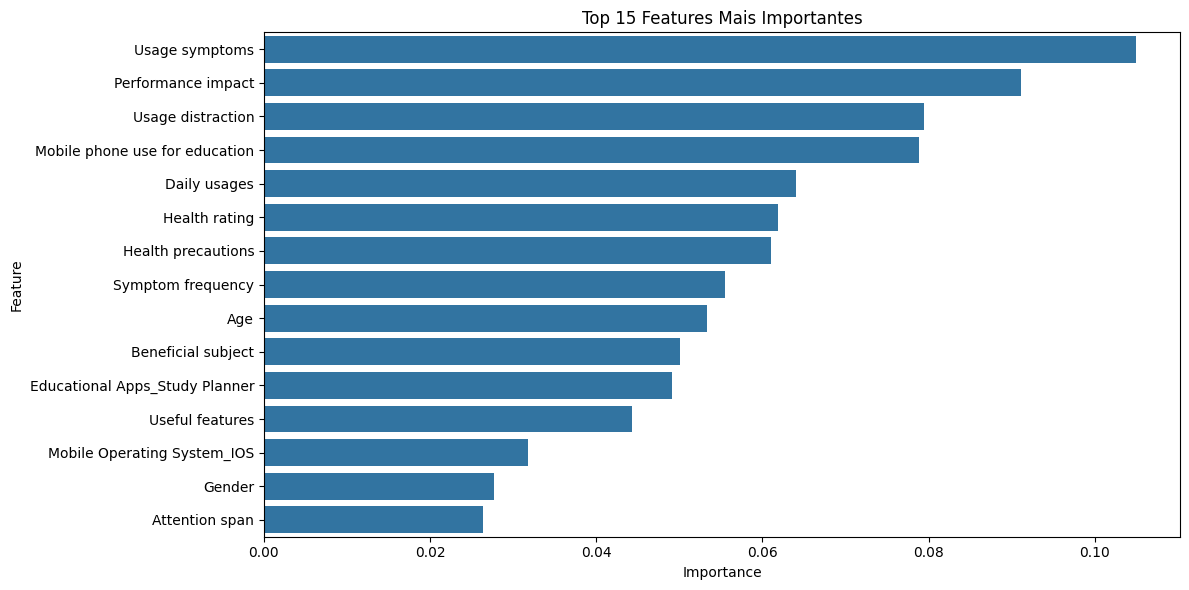

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
feature_names = X.columns

# Criar um DataFrame para visualização
feat_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

# Plotar
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance.head(15))
plt.title('Top 15 Features Mais Importantes')
plt.tight_layout()
# Importância das features
plt.savefig("importancia_features.png")
plt.show()
plt.close()


In [24]:
# Salve as colunas usadas no treinamento
joblib.dump(list(X.columns), "model_columns.joblib")

['model_columns.joblib']

In [25]:
metrics = {
    "acuracia": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred, average='weighted'),
    "sensibilidade": recall_score(y_test, y_pred, average='weighted'),
    "precisao": precision_score(y_test, y_pred, average='weighted')
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f)

In [26]:
# Salvar o modelo treinado
joblib.dump(model, 'modelo_treinado.pkl')

['modelo_treinado.pkl']

In [27]:
# Salve as colunas usadas no treinamento
joblib.dump(list(X.columns), "model_columns.joblib")

['model_columns.joblib']